In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from scipy.special import erf
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_survivor,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide
)


2025-07-04 15:12:27.323 | INFO     | multipathogen_sero.config:<module>:11 - PROJ_ROOT path is: C:\Users\alexy\sero\multipathogen-sero


In [ ]:
# baseline hazards / survivor functions

def get_gaussian_foi(mu,sigma,a):
    """Generate a Gaussian function for the force of infection."""
    return lambda t: np.exp(-((t - mu) ** 2) / (2 * sigma ** 2)) * a
def get_exponential_foi(lam, a):
    """Generate an exponential function for the force of infection."""
    return lambda t: np.exp(-lam * t) * a
def get_gaussian_survivor(mu, sigma, a):
    norm = a * sigma * np.sqrt(np.pi / 2)
    def S(t):
        return np.exp(
            -norm * (erf((t - mu) / (np.sqrt(2) * sigma)) - erf((-mu) / (np.sqrt(2) * sigma)))
        )
    return S
def get_exponential_survivor(lam, a):
    def S(t):
        return np.exp(-a * (1 - np.exp(-lam * t)) / lam)
    return S

Text(0.5, 0, 'Time')

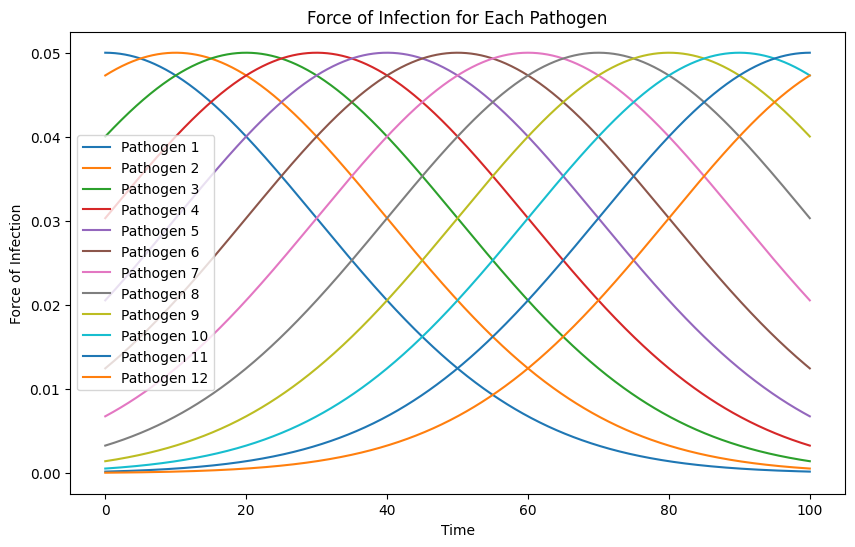

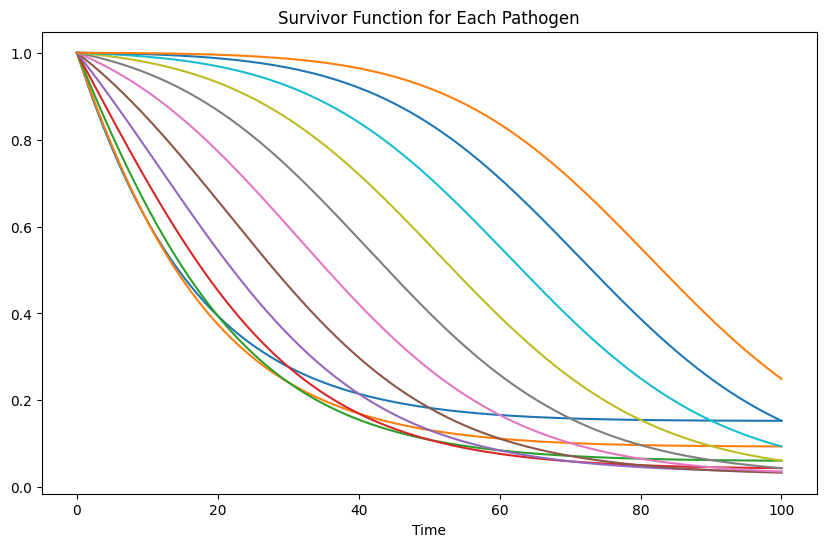

In [ ]:
n_people = 1000 #number of individuals n
np.random.seed(42)  # For reproducibility
birth_times = np.random.uniform(0, 100, size=n_people)  # Random birth times for individuals
n_pathogens=12 #number of pathogens K
t_max=100
pathogen_names = [f'Pathogen {i+1}' for i in range(n_pathogens)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]
foi_list = [
    get_gaussian_foi(mu=10*k, sigma=30, a=0.05) for k in range(n_pathogens)
]
survivor_list = [
    get_gaussian_survivor(mu=10*k, sigma=30, a=0.05) for k in range(n_pathogens)
]

#plot fois
t = np.linspace(0, t_max, 1000)
plt.figure(figsize=(10, 6)) 
for k, foi in enumerate(foi_list):
    plt.plot(t, foi(t), label=pathogen_names[k])
plt.title('Force of Infection for Each Pathogen')
plt.xlabel('Time')
plt.ylabel('Force of Infection')
plt.legend()

#plot survivors
plt.figure(figsize=(10, 6))
for k, survivor in enumerate(survivor_list):
    plt.plot(t, survivor(t), label=pathogen_names[k])
plt.title('Survivor Function for Each Pathogen')
plt.xlabel('Time')

Component 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]
Component 2: [9]


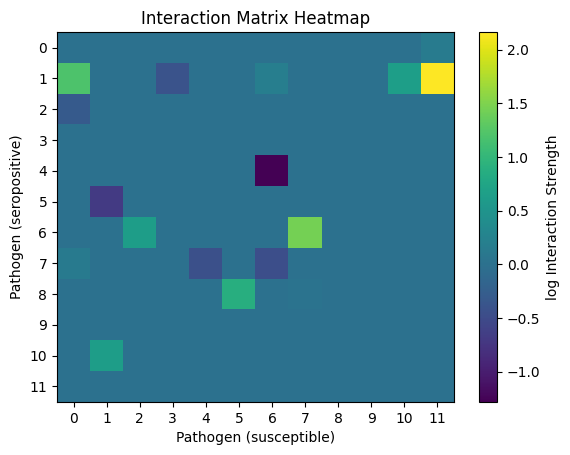

In [6]:
# Interaction matrix

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# spike and slab on each coefficient of the interaction matrix
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
interaction_mat = np.exp(
    np.random.normal(0, 1, size=(n_pathogens, n_pathogens)) * interaction_indicator
)
#plot the interaction matrix as a heatmap
plt.imshow(np.log(interaction_mat), cmap='viridis', aspect='auto')
plt.ylabel('Pathogen (seropositive)')
plt.xlabel('Pathogen (susceptible)')
plt.xticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.yticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.colorbar(label='log Interaction Strength')
plt.title('Interaction Matrix Heatmap')

# Convert interaction_indicator to a sparse matrix
adj_matrix = csr_matrix(interaction_indicator)

# Find weakly connected components (ignoring direction)
n_components, labels = connected_components(csgraph=adj_matrix, directed=True, connection='weak')

# Group node indices by component
components = [np.where(labels == i)[0] for i in range(n_components)]

for i, comp in enumerate(components):
    print(f"Component {i+1}: {comp.tolist()}")

In [7]:
start = time.time()
simulate_infections_df = simulate_infections(n_people, n_pathogens, foi_list, interaction_mat, t_max=t_max, birth_times=birth_times, random_seed=42)
print(f"simulate_infections took {time.time() - start:.3f} seconds")

start = time.time()
simulate_infections_df_alt = simulate_infections_survivor(
    n_people, n_pathogens, survivor_list, interaction_mat, t_max=t_max, birth_times=birth_times, random_seed=42
)
print(f"simulate_infections_survivor took {time.time() - start:.3f} seconds")

simulate_infections took 0.918 seconds
simulate_infections_survivor took 6.071 seconds


In [8]:
pd.set_option('display.max_rows', 30)  # Show all rows in the DataFrame
simulate_infections_df_alt.head(30)  # Display the first 30 rows of the DataFrame

,time,event,individual,pathogen
0,37.454012,birth,0,NaN
1,39.027778,seroconversion,0,1.0
2,41.743505,seroconversion,0,0.0
3,46.633474,seroconversion,0,4.0
4,47.855751,seroconversion,0,3.0
5,49.758170,seroconversion,0,5.0
6,50.786220,seroconversion,0,2.0
7,53.202002,seroconversion,0,11.0
8,59.800823,seroconversion,0,10.0
9,60.079916,seroconversion,0,7.0


In [ ]:
survey_df_long = simulation_to_survey_long(
    simulate_infections_df,
    survey_times=100
)
survey_df_wide = survey_long_to_wide(survey_df_long)

survey_df_long_alt = simulation_to_survey_long(
    simulate_infections_df_alt,
    survey_times=100
)
survey_df_wide_alt = survey_long_to_wide(survey_df_long_alt)

# Checking for validity

In [10]:
n_people=10000 #number of individuals n
np.random.seed(42)  # For reproducibility
birth_times = np.random.uniform(0, 100, size=n_people)  # Random birth times for individuals
n_pathogens=12 #number of pathogens K
pathogen_names = [f'Pathogen {i+1}' for i in range(n_pathogens)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]
foi_list = [
    get_gaussian_foi(mu=10*k, sigma=30, a=0.05) for k in range(n_pathogens)
]
survivor_list = [
    get_gaussian_survivor(mu=10*k, sigma=30, a=0.05) for k in range(n_pathogens)
]
# spike and slab on each coefficient of the interaction matrix
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
interaction_mat = np.exp(
    np.random.normal(0, 1, size=(n_pathogens, n_pathogens)) * interaction_indicator
)
start = time.time()
simulate_infections_df = simulate_infections(n_people, n_pathogens, foi_list, interaction_mat, t_max=100, birth_times=birth_times, random_seed=42)
print(f"simulate_infections took {time.time() - start:.3f} seconds")

start = time.time()
simulate_infections_df_alt = simulate_infections_survivor(
    n_people, n_pathogens, survivor_list, interaction_mat, t_max=100, birth_times=birth_times, random_seed=42
)
print(f"simulate_infections_survivor took {time.time() - start:.3f} seconds")
survey_df_long = survey_from_simulation(
    simulate_infections_df,
    survey_times=100
)
survey_df_wide = survey_df_long_to_wide(survey_df_long)
survey_df_long_alt = survey_from_simulation(
    simulate_infections_df_alt,
    survey_times=100
)

seroprop = survey_df_long.groupby('pathogen')['serostatus'].mean()
seroprop_alt = survey_df_long_alt.groupby('pathogen')['serostatus'].mean()
# Plot grouped bar chart for seropositivity proportions from both simulations
x = np.arange(n_pathogens)
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, seroprop.values, width, label='simulate_infections', color='blue')
plt.bar(x + width/2, seroprop_alt.values, width, label='simulate_infections_survivor', color='orange')
plt.ylabel('Seropositivity Proportion')
plt.xlabel('Pathogen')
plt.title('Seropositivity Proportion Comparison')
plt.xticks(x, [f'{k}' for k in range(n_pathogens)])
plt.legend()
plt.tight_layout()
plt.show()


simulate_infections took 9.576 seconds
simulate_infections_survivor took 53.352 seconds


NameError: name 'survey_from_simulation' is not defined

In [42]:
# For each individual, find the first seroconversion event (if any)
def get_first_seroconversion(sim_df: pd.DataFrame, t_end: float) -> pd.DataFrame:
    sero = sim_df[sim_df['event'] == 'seroconversion']
    # Sort by time to ensure first event is picked
    sero_sorted = sero.sort_values(['individual', 'time'])
    # Get first seroconversion per individual
    first_sero = sero_sorted.groupby('individual', as_index=False).first()
    # Prepare output DataFrame
    result = pd.DataFrame({'individual': np.arange(n_people)})
    result = result.merge(
        first_sero[['individual', 'time', 'pathogen']],
        on='individual',
        how='left'
    )
    # Fill missing with t_end and NA for pathogen
    result['time'] = result['time'].fillna(t_end)
    result['pathogen'] = result['pathogen']
    return result

first_seroconversion_df = get_first_seroconversion(simulate_infections_df, t_end=100)
first_seroconversion_df

,individual,time,pathogen
0,0,55.485640,10.0
1,1,17.661864,2.0
2,2,41.686851,2.0
3,3,20.861067,1.0
4,4,98.536873,8.0
...,...,...,...
9995,9995,32.180132,1.0
9996,9996,55.051045,7.0
9997,9997,3.838575,1.0
9998,9998,10.138063,3.0


Text(0, 0.5, 'Survival Probability')

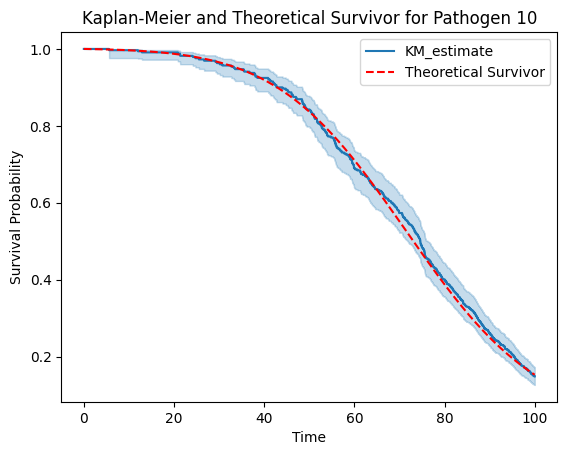

In [ ]:

k = 10

# left truncation times (birth times)
entry = birth_times

# Time when subject exited the study (either event or censoring)
exit = first_seroconversion_df['time'].values

# Whether the event (e.g., death) occurred (1) or was censored (0)
event_observed = (first_seroconversion_df['pathogen'].values)==k

kmf = KaplanMeierFitter()
kmf.fit(durations=exit, event_observed=event_observed, entry=entry)

kmf.plot_survival_function()

# Plot the theoretical survivor function for pathogen k
t_grid = np.linspace(entry.min(), exit.max(), 500)
S_theoretical = survivor_list[k](t_grid)
plt.plot(t_grid, S_theoretical, label='Theoretical Survivor', color='red', linestyle='--')
plt.legend()
plt.title(f'Kaplan-Meier and Theoretical Survivor for Pathogen {k}')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Analysis

In [67]:
def plot_histogram(
        infections_df: pd.DataFrame,
        pathogen_number: int = 0
    ) -> None:
    relevant_infections = infections_df[infections_df['pathogen'] == pathogen_number]
    plt.figure(figsize=(10, 6))
    plt.hist(relevant_infections['time'], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Infection Times for pathogen {pathogen_number}')

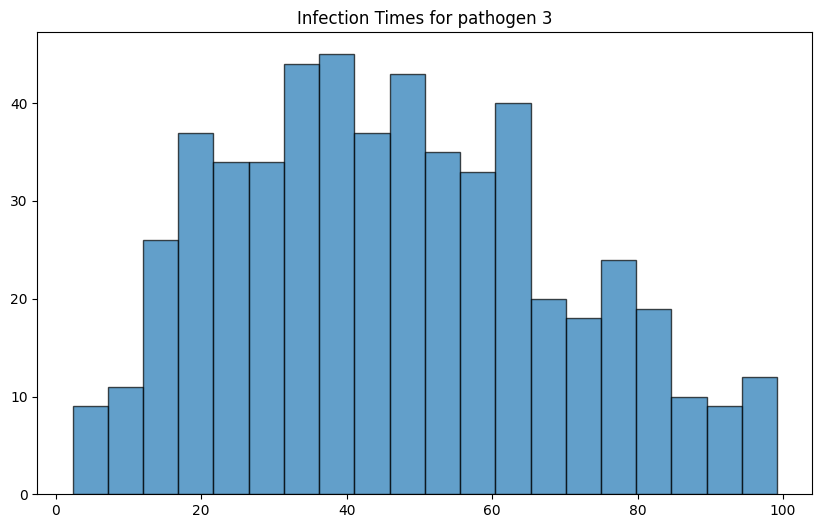

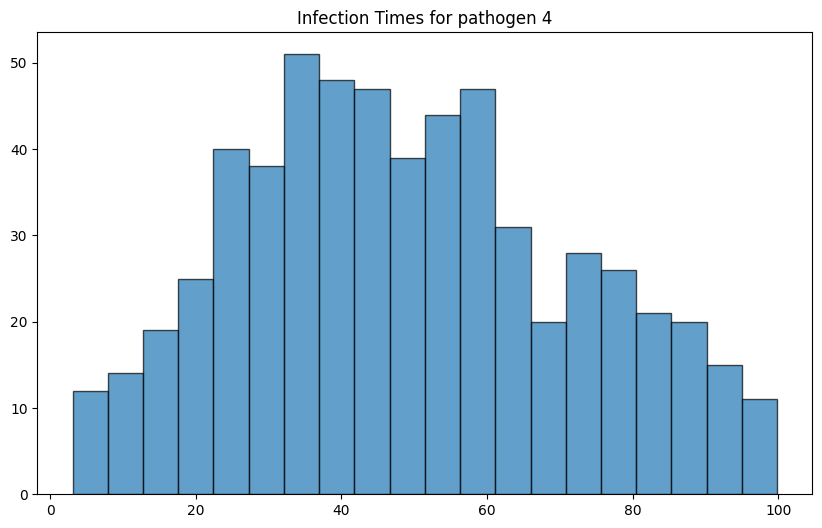

In [78]:
plot_histogram(simulate_infections_df, pathogen_number=3)
plot_histogram(simulate_infections_df, pathogen_number=4)

Text(0.5, 1.0, 'Interaction Matrix Heatmap')

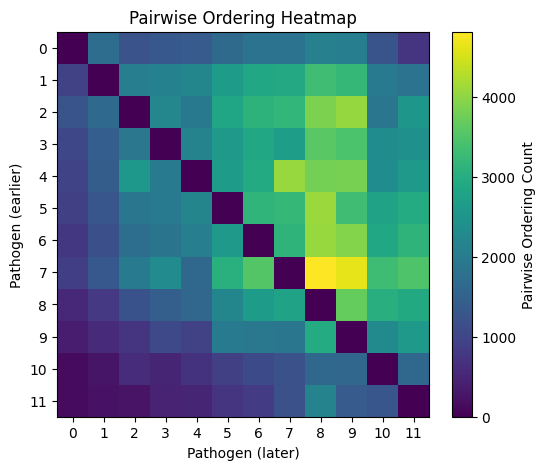

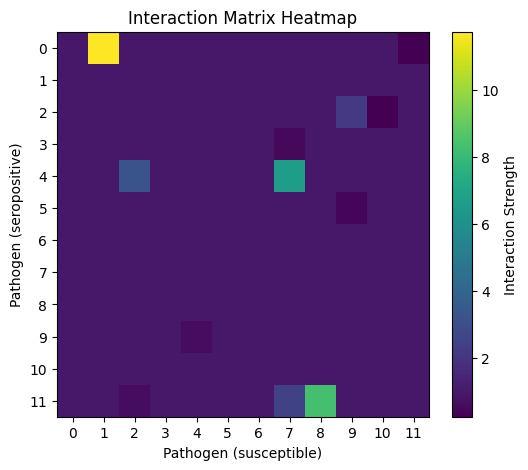

In [36]:
def compute_pairwise_ordering(infections_df, n_people, n_pathogens):
    # Initialize the matrix
    pairwise_ordering = np.zeros((n_pathogens, n_pathogens), dtype=int)
    # Group by individual
    infections_df = infections_df[infections_df['event'] == 'seroconversion']
    grouped = infections_df.groupby('individual')
    for _, group in grouped:
        # Get infection times for this individual
        times = np.full(n_pathogens, np.inf)
        times[group['pathogen'].values.astype(int)] = group['time'].values
        for k in range(n_pathogens):
            for kp in range(n_pathogens):
                if k != kp and np.isfinite(times[k]) and np.isfinite(times[kp]):
                    if times[k] < times[kp]:
                        pairwise_ordering[k, kp] += 1   
    return pairwise_ordering

# Example usage:
pairwise_ordering = compute_pairwise_ordering(simulate_infections_df, n_people, n_pathogens)
#plot as heatmap
plt.figure(figsize=(6, 5))
plt.imshow(pairwise_ordering, cmap='viridis', aspect='auto')
plt.ylabel('Pathogen (earlier)')
plt.xlabel('Pathogen (later)')
plt.xticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.yticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.colorbar(label='Pairwise Ordering Count')
plt.title('Pairwise Ordering Heatmap')
plt.figure(figsize=(6, 5))
plt.imshow(interaction_mat, cmap='viridis', aspect='auto')
plt.ylabel('Pathogen (seropositive)')
plt.xlabel('Pathogen (susceptible)')
plt.xticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.yticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.colorbar(label='Interaction Strength')
plt.title('Interaction Matrix Heatmap')

# Testing for independence

Number of individuals born between 30 and 35: 521


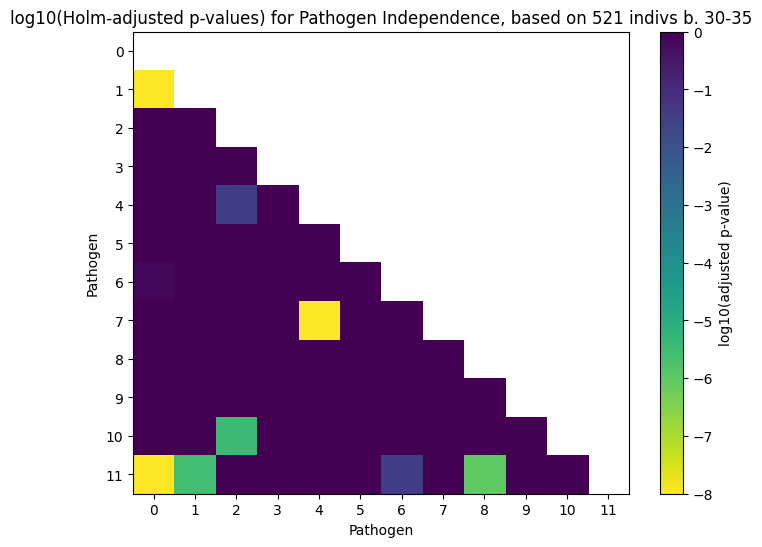

In [90]:
birth_time_lower = 30
birth_time_upper = 35
individuals_in_bin = np.where(
    (birth_times >= birth_time_lower) & (birth_times < birth_time_upper)
)[0]
print(f"Number of individuals born between {birth_time_lower} and {birth_time_upper}: {len(individuals_in_bin)}")
filtered_survey = survey_df_long[survey_df_long['individual'].isin(individuals_in_bin)]
filtered_survey_wide = survey_df_long_to_wide(filtered_survey)


# Collect all off-diagonal p-values
pvals = []
indices = []
for k1 in range(n_pathogens):
    for k2 in range(k1 + 1, n_pathogens):
        contingency_table = pd.crosstab(
            filtered_survey_wide[f'serostatus_{k1}'],
            filtered_survey_wide[f'serostatus_{k2}']
        )
        tbl = Table2x2(contingency_table)
        p_value = tbl.test_nominal_association().pvalue
        pvals.append(p_value)
        indices.append((k1, k2))

# Holm correction
_, pvals_holm, _, _ = multipletests(pvals, method='holm')

# Fill adjusted p-values into a matrix (symmetric)
pval_matrix_adj = np.ones((n_pathogens, n_pathogens))
for (k1, k2), adj_p in zip(indices, pvals_holm):
    pval_matrix_adj[k1, k2] = adj_p
    pval_matrix_adj[k2, k1] = adj_p

# Clip for plotting
pval_matrix_adj_clipped = np.clip(pval_matrix_adj, 1e-8, 1)

mask = np.triu(np.ones_like(pval_matrix_adj_clipped, dtype=bool), k=0)  # k=0 masks diagonal too
masked_matrix = np.ma.masked_where(mask, np.log10(pval_matrix_adj_clipped))

plt.figure(figsize=(8, 6))
im = plt.imshow(masked_matrix, cmap='viridis_r', aspect='auto', vmin=-8, vmax=0)
plt.colorbar(im, label='log10(adjusted p-value)')
plt.title(f'log10(Holm-adjusted p-values) for Pathogen Independence, based on {len(individuals_in_bin)} indivs b. {birth_time_lower}-{birth_time_upper}')
plt.xlabel('Pathogen')
plt.ylabel('Pathogen')
plt.xticks(np.arange(n_pathogens), np.arange(n_pathogens))
plt.yticks(np.arange(n_pathogens), np.arange(n_pathogens))
plt.show()

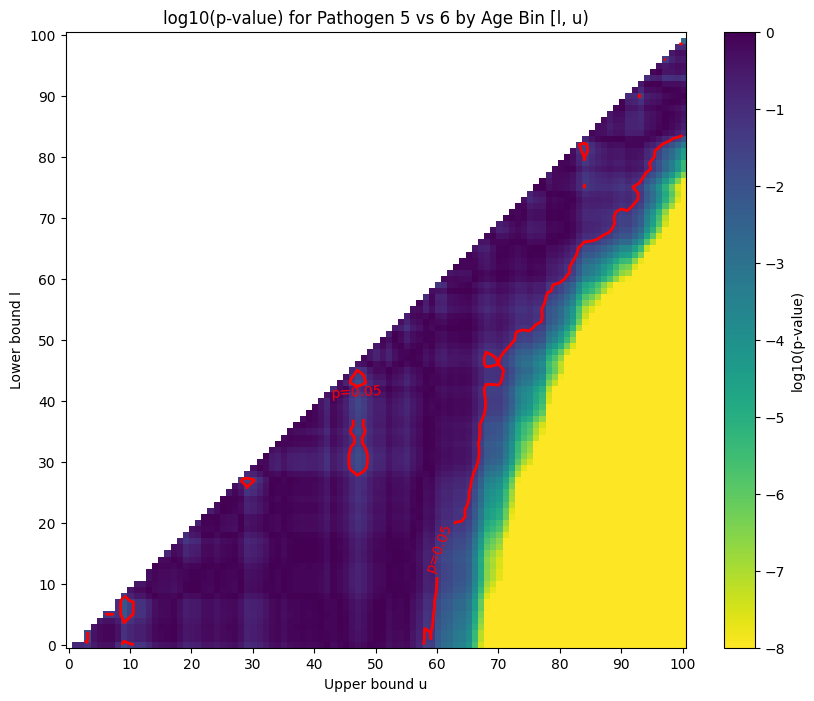

In [112]:
k1, k2 = 5,6  # Pathogen indices to compare
max_age = int(np.ceil(birth_times.max()))
min_age = int(np.floor(birth_times.min()))
heatmap_size = max_age - min_age + 1

# Convert once to wide format
survey_df_wide = survey_df_long_to_wide(survey_df_long)

# Precompute birth times for all individuals
individual_birth_times = survey_df_wide.merge(
    pd.DataFrame({'individual': np.arange(len(birth_times)), 'birth_time': birth_times}),
    on='individual'
)

# Precompute contingency tables for each [t, t+1) bin
contingency_tables = []
for t in range(min_age, max_age):
    in_bin = (individual_birth_times['birth_time'] >= t) & (individual_birth_times['birth_time'] < t + 1)
    filtered = individual_birth_times[in_bin]
    if (f'serostatus_{k1}' in filtered.columns and
        f'serostatus_{k2}' in filtered.columns and
        filtered[f'serostatus_{k1}'].nunique() > 1 and
        filtered[f'serostatus_{k2}'].nunique() > 1):
        ct = pd.crosstab(filtered[f'serostatus_{k1}'], filtered[f'serostatus_{k2}'])
        # Ensure 2x2 shape for summing later
        ct = ct.reindex(index=[0,1], columns=[0,1], fill_value=0)
        contingency_tables.append(ct.values)
    else:
        contingency_tables.append(np.zeros((2,2), dtype=int))


pval_matrix = np.full((heatmap_size, heatmap_size), np.nan)

# Efficiently sum contingency tables for each [l, u) bin
for l in range(min_age, max_age):
    cumsum = np.zeros((2,2), dtype=int)
    for u in range(l + 1, max_age + 1):
        cumsum += contingency_tables[u - min_age - 1]  # [l, u): add bin u-1
        if cumsum.sum() < 5 or np.any(cumsum.sum(axis=0) == 0) or np.any(cumsum.sum(axis=1) == 0):
            continue
        tbl = Table2x2(cumsum)
        p_value = tbl.test_nominal_association().pvalue
        pval_matrix[l - min_age, u - min_age] = p_value

log_pval_matrix = np.log10(pval_matrix)
log_pval_matrix_clipped = np.where(np.isnan(log_pval_matrix), np.nan, np.maximum(log_pval_matrix, -8))

plt.figure(figsize=(10, 8))
im = plt.imshow(log_pval_matrix_clipped, origin='lower', aspect='auto', cmap='viridis_r', vmin=-8, vmax=0)
plt.colorbar(im, label='log10(p-value)')
plt.xlabel('Upper bound u')
plt.ylabel('Lower bound l')
plt.title(f'log10(p-value) for Pathogen {k1} vs {k2} by Age Bin [l, u)')

# Draw contour for p = 0.05
from matplotlib import ticker
X, Y = np.meshgrid(np.arange(pval_matrix.shape[1]), np.arange(pval_matrix.shape[0]))
contour = plt.contour(
    X, Y, pval_matrix, levels=[0.05], colors='red', linewidths=2, origin='lower'
)
plt.clabel(contour, fmt={0.05: 'p=0.05'}, colors='red', fontsize=10)

# Ticks every 10 years
tick_step = 10
xtick_locs = np.arange(0, heatmap_size, tick_step)
ytick_locs = np.arange(0, heatmap_size, tick_step)
plt.xticks(xtick_locs, (min_age + xtick_locs).astype(int))
plt.yticks(ytick_locs, (min_age + ytick_locs).astype(int))

plt.show()

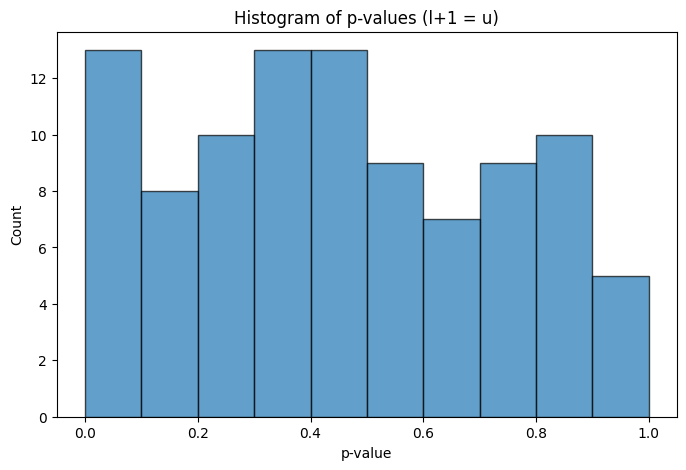

In [89]:
pvals_diag = np.diag(pval_matrix, k=1)  # k=1 gives the diagonal just above the main

# Remove NaNs
pvals_diag = pvals_diag[~np.isnan(pvals_diag)]

# Plot histogram with binwidth 0.1
plt.figure(figsize=(8, 5))
plt.hist(pvals_diag, bins=np.arange(0, 1.01, 0.1), edgecolor='black', alpha=0.7)
plt.xlabel('p-value')
plt.ylabel('Count')
plt.title('Histogram of p-values (l+1 = u)')
plt.show()

# frailty

In [93]:
def simulate_infections_with_frailties(
        n_people: int,
        n_pathogens: int,
        foi_list: List[Callable[[Union[float, np.ndarray]], np.ndarray]],
        interaction_mat: Optional[np.ndarray],
        t_max: float = 100,
        birth_times: Optional[np.ndarray] = None,
        frailties: Optional[np.ndarray] = None,
        foi_max: Optional[np.ndarray] = None,
        random_seed: Optional[int] = None
    ) -> pd.DataFrame:
    """
    Simulate infections using thinning of Poisson process.
    Parameters:
        n_people (int): Number of individuals.
        n_pathogens (int): Number of pathogens.
        fois (Callable[[float], np.ndarray]): Function that returns the forces of infection at time t for each pathogen.
        interaction_mat (Optional[np.ndarray]): Interaction matrix for pathogens. The k,l entry indicates the effect of pathogen k on pathogen l.
        birth_times (Optional[np.ndarray]): Birth times for each individual. If None, individuals are assumed to be born at time 0.
        t_max (float): Maximum time for the simulation.
        foi_max (Optional[np.ndarray]): Maximum force of infection values for each pathogen.
        random_seed (Optional[int]): Random seed for reproducibility.
    
    """
    if birth_times is None:
        birth_times = np.zeros(n_people, dtype=float)
    if frailties is None:
        frailties = np.ones(n_people, dtype=float)
    if random_seed is not None:
        np.random.seed(random_seed)
    if interaction_mat is None:
        interaction_mat = np.ones((n_pathogens, n_pathogens))
    if foi_max is None:
        t_grid = np.linspace(0, t_max, 1000)
        foi_max = np.array([foi_list[k](t_grid).max() for k in range(n_pathogens)])
        foi_max *= 1.1 # leeway for discretization errors
    assert foi_max is not None  # for type checkers
    
    infection_times = []
    for i in range(n_people):
        birth_time = birth_times[i]
        frailty = frailties[i]
        infection_times.append((birth_time, 'birth', i, None))
        t_current = birth_time
        infection_status = np.zeros(n_pathogens, dtype=bool)  # Track infections for each pathogen
        susceptibility_factors = np.prod(interaction_mat[infection_status], axis=0) * frailty
        while True: #simulate until t_max reached or np.all(infection_status)
            proposal_indices = np.where(infection_status == 0)[0] # Indices of pathogens not yet infected
            proposal_times = np.full(len(proposal_indices), t_current, dtype=float) # Initialize proposal times for pathogens not yet infected
            earliest_accepted_proposal = np.inf
            earliest_accepted_proposal_index = None
            while proposal_indices.size > 0:
                # generate proposal times for each pathogen
                proposal_times += np.random.exponential(
                    1 / foi_max[proposal_indices] / susceptibility_factors[proposal_indices],
                    size=len(proposal_indices)
                )
                #thinning step
                accept_probs = np.array(
                    [foi_list[k](proposal_times[j]) / foi_max[k] for j, k in enumerate(proposal_indices)]
                )
                accept_mask = np.random.uniform(0, 1, size=len(proposal_indices)) < accept_probs
                #updates
                if np.any(accept_mask):
                    if proposal_times[accept_mask].min() < earliest_accepted_proposal:
                        # Update the earliest accepted proposal if a new one is found
                        accepted_proposal_indices = proposal_indices[accept_mask]
                        accepted_proposal_times = proposal_times[accept_mask]
                        earliest_accepted_proposal_index = accepted_proposal_indices[np.argmin(accepted_proposal_times)]
                        earliest_accepted_proposal = accepted_proposal_times.min()
                # continue generating for pathogens that still have a chance to infect earlier than the current earliest
                continue_mask = proposal_times < min(earliest_accepted_proposal, t_max)
                proposal_indices = proposal_indices[continue_mask]
                proposal_times = proposal_times[continue_mask]
            if earliest_accepted_proposal > t_max:
                break
            else:
                assert earliest_accepted_proposal_index is not None
            t_current = earliest_accepted_proposal
            k = earliest_accepted_proposal_index
            infection_times.append((t_current, 'seroconversion', i, k))
            infection_status[k] = 1
            if np.all(infection_status):
                break
            susceptibility_factors = np.prod(interaction_mat[infection_status], axis=0) * frailty
    return pd.DataFrame(infection_times, columns=['time', 'event', 'individual', 'pathogen'])

In [103]:
frailties = np.exp(np.random.normal(0, 0.5, size=n_people))  # Random frailties for individuals
simulate_infections_with_frailties_df = simulate_infections_with_frailties(n_people, n_pathogens, foi_list, interaction_mat, t_max=100, birth_times=birth_times, frailties=frailties, random_seed=42)

In [104]:
survey_with_frailties_df_long = survey_from_simulation(
    simulate_infections_with_frailties_df,
    survey_times=100
)
survey_with_frailties_df_wide = survey_df_long_to_wide(survey_with_frailties_df_long)

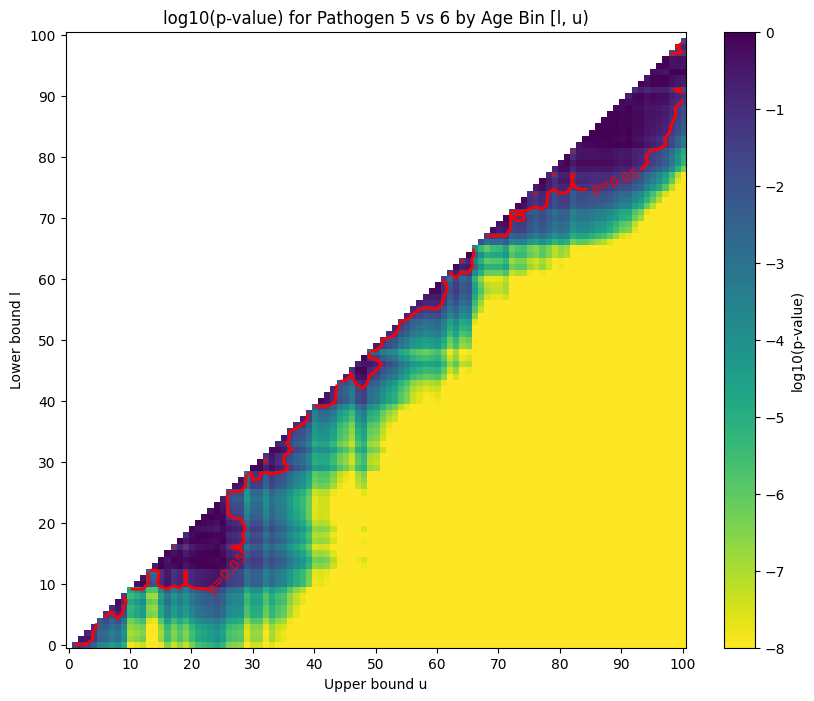

In [113]:
k1, k2 = 5,6  # Pathogen indices to compare
max_age = int(np.ceil(birth_times.max()))
min_age = int(np.floor(birth_times.min()))
heatmap_size = max_age - min_age + 1


# Precompute birth times for all individuals
individual_birth_times = survey_with_frailties_df_wide.merge(
    pd.DataFrame({'individual': np.arange(len(birth_times)), 'birth_time': birth_times}),
    on='individual'
)

# Precompute contingency tables for each [t, t+1) bin
contingency_tables = []
for t in range(min_age, max_age):
    in_bin = (individual_birth_times['birth_time'] >= t) & (individual_birth_times['birth_time'] < t + 1)
    filtered = individual_birth_times[in_bin]
    if (f'serostatus_{k1}' in filtered.columns and
        f'serostatus_{k2}' in filtered.columns and
        filtered[f'serostatus_{k1}'].nunique() > 1 and
        filtered[f'serostatus_{k2}'].nunique() > 1):
        ct = pd.crosstab(filtered[f'serostatus_{k1}'], filtered[f'serostatus_{k2}'])
        # Ensure 2x2 shape for summing later
        ct = ct.reindex(index=[0,1], columns=[0,1], fill_value=0)
        contingency_tables.append(ct.values)
    else:
        contingency_tables.append(np.zeros((2,2), dtype=int))


pval_matrix = np.full((heatmap_size, heatmap_size), np.nan)

# Efficiently sum contingency tables for each [l, u) bin
for l in range(min_age, max_age):
    cumsum = np.zeros((2,2), dtype=int)
    for u in range(l + 1, max_age + 1):
        cumsum += contingency_tables[u - min_age - 1]  # [l, u): add bin u-1
        if cumsum.sum() < 5 or np.any(cumsum.sum(axis=0) == 0) or np.any(cumsum.sum(axis=1) == 0):
            continue
        tbl = Table2x2(cumsum)
        p_value = tbl.test_nominal_association().pvalue
        pval_matrix[l - min_age, u - min_age] = p_value

log_pval_matrix = np.log10(pval_matrix)
log_pval_matrix_clipped = np.where(np.isnan(log_pval_matrix), np.nan, np.maximum(log_pval_matrix, -8))

plt.figure(figsize=(10, 8))
im = plt.imshow(log_pval_matrix_clipped, origin='lower', aspect='auto', cmap='viridis_r', vmin=-8, vmax=0)
plt.colorbar(im, label='log10(p-value)')
plt.xlabel('Upper bound u')
plt.ylabel('Lower bound l')
plt.title(f'log10(p-value) for Pathogen {k1} vs {k2} by Age Bin [l, u)')

# Draw contour for p = 0.05
from matplotlib import ticker
X, Y = np.meshgrid(np.arange(pval_matrix.shape[1]), np.arange(pval_matrix.shape[0]))
contour = plt.contour(
    X, Y, pval_matrix, levels=[0.05], colors='red', linewidths=2, origin='lower'
)
plt.clabel(contour, fmt={0.05: 'p=0.05'}, colors='red', fontsize=10)

# Ticks every 10 years
tick_step = 10
xtick_locs = np.arange(0, heatmap_size, tick_step)
ytick_locs = np.arange(0, heatmap_size, tick_step)
plt.xticks(xtick_locs, (min_age + xtick_locs).astype(int))
plt.yticks(ytick_locs, (min_age + ytick_locs).astype(int))

plt.show()

# Cox regression

In [ ]:

#  1. Rename columns
regression_df = simulate_infections_df.rename(
    columns={
        "time": "start_time",
        "event": "start_event",
        "pathogen": "start_event_pathogen"
    }
)

# 2. Sort for groupby operations
regression_df = regression_df.sort_values(['individual', 'start_time'])

# 3. Add stop_time, stop_event, stop_event_pathogen
regression_df[['stop_time', 'stop_event', 'stop_event_pathogen']] = (
    regression_df.groupby('individual')[['start_time', 'start_event', 'start_event_pathogen']]
    .shift(-1)
)
regression_df['stop_time'] = regression_df['stop_time'].fillna(t_max)
regression_df['stop_event'] = regression_df['stop_event'].fillna('censor')
regression_df['stop_event_pathogen'] = regression_df['stop_event_pathogen']

# 4. Add serostatus columns for each pathogen at start_time
n_pathogens = int(simulate_infections_df['pathogen'].dropna().max()) + 1

for k in range(n_pathogens):
    # For each row, check if there was a seroconversion for pathogen k before or at start_time
    sero_times = simulate_infections_df[
        (simulate_infections_df['event'] == 'seroconversion') &
        (simulate_infections_df['pathogen'] == k)
    ][['individual', 'time']]
    sero_times = sero_times.rename(columns={'time': f'seroconv_time_{k}'})
    # Merge to get seroconversion time for each individual
    regression_df = regression_df.merge(
        sero_times, on='individual', how='left'
    )
    regression_df[f'serostatus_{k}'] = (
        (regression_df[f'seroconv_time_{k}'].notna()) &
        (regression_df['start_time'] >= regression_df[f'seroconv_time_{k}'])
    ).astype(int)
    regression_df = regression_df.drop(columns=[f'seroconv_time_{k}'])

# Optional: reset index if needed
regression_df = regression_df.reset_index(drop=True)

In [152]:
regression_df

,start_time,start_event,individual,start_event_pathogen,stop_time,stop_event,stop_event_pathogen,serostatus_0,serostatus_1,serostatus_2,serostatus_3,serostatus_4,serostatus_5,serostatus_6,serostatus_7,serostatus_8,serostatus_9,serostatus_10,serostatus_11
0,55.107471,birth,0,NaN,55.485640,seroconversion,10.0,0,0,0,0,0,0,0,0,0,0,0,0
1,55.485640,seroconversion,0,10.0,56.350438,seroconversion,5.0,0,0,0,0,0,0,0,0,0,0,1,0
2,56.350438,seroconversion,0,5.0,60.066597,seroconversion,3.0,0,0,0,0,0,1,0,0,0,0,1,0
3,60.066597,seroconversion,0,3.0,60.167277,seroconversion,8.0,0,0,0,1,0,1,0,0,0,0,1,0
4,60.167277,seroconversion,0,8.0,65.624497,seroconversion,9.0,0,0,0,1,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82112,93.316183,seroconversion,9998,11.0,100.000000,censor,NaN,1,1,1,1,1,1,1,1,1,1,0,1
82113,85.573934,birth,9999,NaN,96.070130,seroconversion,5.0,0,0,0,0,0,0,0,0,0,0,0,0
82114,96.070130,seroconversion,9999,5.0,96.110142,seroconversion,10.0,0,0,0,0,0,1,0,0,0,0,0,0
82115,96.110142,seroconversion,9999,10.0,97.169060,seroconversion,9.0,0,0,0,0,0,1,0,0,0,0,1,0


<lifelines.CoxTimeVaryingFitter: fitted with 864 periods, 200 subjects, 169 events>
         event col = 'event'
number of subjects = 200
 number of periods = 864
  number of events = 169
partial log-likelihood = -533.15
  time fit was run = 2025-07-03 11:48:12 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
serostatus_0  -0.09      0.91      0.24           -0.56            0.37                0.57                1.45
serostatus_1   0.19      1.21      0.23           -0.27            0.65                0.76                1.91
serostatus_2   0.09      1.10      0.22           -0.33            0.51                0.72                1.67
serostatus_3  -1.10      0.33      0.22           -1.53           -0.67                0.22                0.51
serostatus_4   2.07      7.93      0.20            1.68            2.46                5.39               11.67
serostatus_5   0.17      1.19      0.20           -0.21            0.56                0.81                1.75
serostatus_6  -0.16      0.86      0.18           -0.50            0.19                0.61                1.21
serostatus_8   0.22      1.25      0.19           -0.15            0.60                0.86                1.82
serostatus_9  -0.16      0.85      0.25           -0.64            0.33                0.53                1.38
serostatus_10 -0.06      0.94      0.29           -0.63            0.50                0.53                1.64
serostatus_11  0.64      1.90      0.28            0.09            1.19                1.09                3.29

               cmp to     z      p  -log2(p)
covariate                                   
serostatus_0     0.00 -0.40   0.69      0.54
serostatus_1     0.00  0.80   0.42      1.24
serostatus_2     0.00  0.42   0.67      0.58
serostatus_3     0.00 -5.03 <0.005     20.95
serostatus_4     0.00 10.51 <0.005     83.49
serostatus_5     0.00  0.88   0.38      1.40
serostatus_6     0.00 -0.89   0.37      1.42
serostatus_8     0.00  1.18   0.24      2.07
serostatus_9     0.00 -0.64   0.52      0.94
serostatus_10    0.00 -0.22   0.82      0.28
serostatus_11    0.00  2.28   0.02      5.46
---
Partial AIC = 1088.30
log-likelihood ratio test = 144.94 on 11 df
-log2(p) of ll-ratio test = 82.36

Number of individuals in the subsample: 200
Ground truth effect sizes for pathogen 7: [1.         1.         1.         0.4895095  6.66448701 1.
 1.         1.         1.         1.         1.         2.50393113]


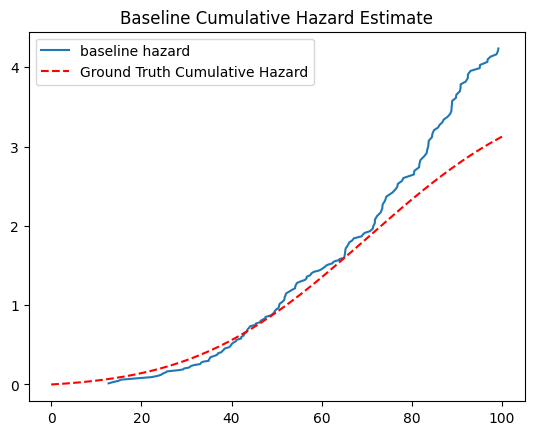

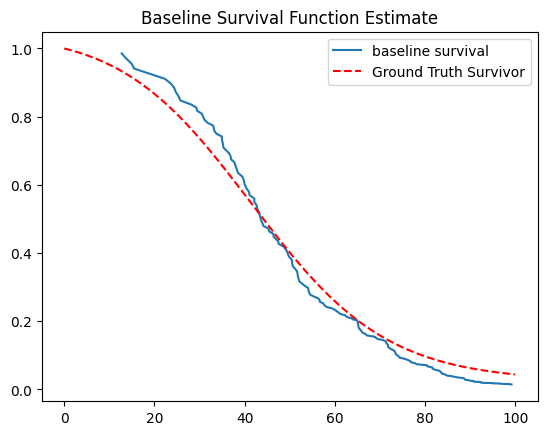

In [151]:
k = 7

# Filter for intervals where individual is seronegative for pathogen k at start_time
regression_df_for_pathogen_k = regression_df[regression_df[f'serostatus_{k}'] == 0].copy()

# Add event column: 1 if seroconversion for k occurs at stop_event, else 0
regression_df_for_pathogen_k['event'] = (
    (regression_df_for_pathogen_k['stop_event'] == 'seroconversion') &
    (regression_df_for_pathogen_k['stop_event_pathogen'] == k)
).astype(int)

# Drop unnecessary columns
regression_df_for_pathogen_k = regression_df_for_pathogen_k.drop(
    columns=[
        'start_event', 'start_event_pathogen', 'stop_event', 'stop_event_pathogen', f'serostatus_{k}'
    ]
)
n_people_subsample = 200
regression_df_for_pathogen_k_subsampled = regression_df_for_pathogen_k[regression_df_for_pathogen_k["individual"]<n_people_subsample]

# Instantiate the CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

# Fit the model
ctv.fit(regression_df_for_pathogen_k_subsampled, id_col = "individual", start_col="start_time", stop_col="stop_time", event_col="event")

# Print summary
ctv.print_summary()

print(f"Number of individuals in the subsample: {len(regression_df_for_pathogen_k_subsampled['individual'].unique())}")
print(f"Ground truth effect sizes for pathogen {k}: {interaction_mat[:, k]}")

# Plot baseline cumulative hazard with ground truth cumulative hazard
ax = ctv.baseline_cumulative_hazard_.plot(title="Baseline Cumulative Hazard Estimate")
t_grid = np.linspace(0, t_max, 500)
# Ground truth cumulative hazard: -log(S(t))
S_theoretical = survivor_list[k](t_grid)
cumhaz_theoretical = -np.log(S_theoretical)
ax.plot(t_grid, cumhaz_theoretical, label='Ground Truth Cumulative Hazard', color='red', linestyle='--')
ax.legend()

# Plot baseline survival with ground truth survivor
ax2 = ctv.baseline_survival_.plot(title="Baseline Survival Function Estimate")
ax2.plot(t_grid, S_theoretical, label='Ground Truth Survivor', color='red', linestyle='--')
ax2.legend()
